# Zonal Analysis

PyLandStats feautures specific classes to evaluate how the metrics change accross the landscape. In this notebook, we will assess how the forests change depending on the elevation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylandstats as pls
import rasterio as rio

In [2]:
metrics = ['proportion_of_landscape', 'patch_density', 'edge_density', 'fractal_dimension_am']
class_dict = {10: 'Forest (no bushes)', 11: 'Bushy forest', 12: 'Other forest'}
classes = list(class_dict.keys())

lulc_filepaths = [
    f'../data/raw/{lulc_filename}.tif'
    for lulc_filename in ['AS85R_17', 'AS97R_17', 'AS09R_17', 'AS18_17']
]
years = [1980, 1990, 2005, 2014]

# dem
dem_filepath = '../data/raw/dem.tif'

Let us use rasterio to explore the DEM:

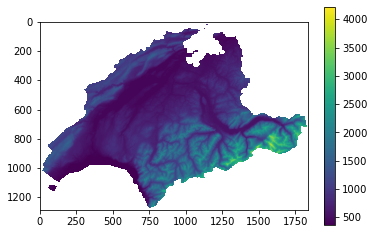

In [3]:
with rio.open(dem_filepath) as src:
    dem_arr = src.read(1)
plt.imshow(dem_arr)
plt.colorbar()

Let us replace `np.nan` values with -1 to ensure that lower/equal/greater than comparison are performed correctly

In [4]:
dem_arr[np.isnan(dem_arr)] = -1

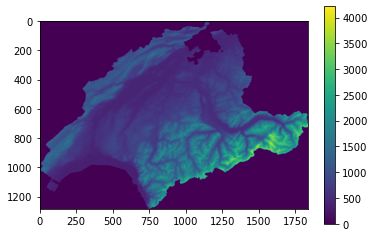

In [5]:
plt.imshow(dem_arr)
plt.colorbar()

Let us now use the `digitize` function of NumPy to divide our landscape into altitude strata

In [6]:
alt_strata = [0, 1000, 1500, 2000]

dem_strata_arr = np.digitize(dem_arr, alt_strata)

Let us now plot the result

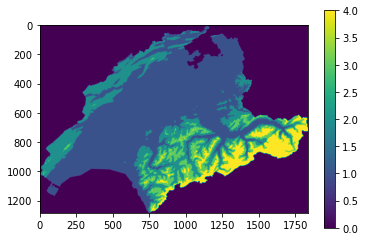

In [7]:
plt.imshow(dem_strata_arr)
plt.colorbar()

In order to perform a `ZonalAnalysis` with PyLandStats, we will build boolean masks for each altitude strata:

In [8]:
masks = []

for i in range(1, 5):
    mask_arr = np.full_like(dem_strata_arr, False)
    mask_arr[dem_strata_arr == i] = True
    masks.append(mask_arr)

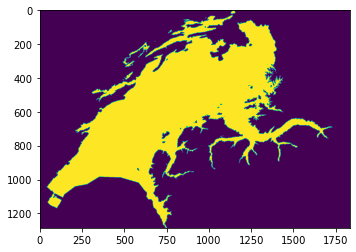

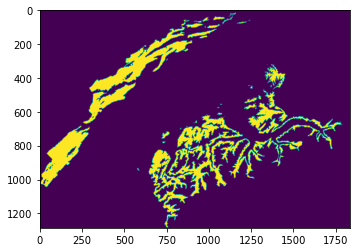

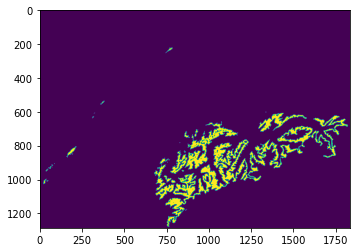

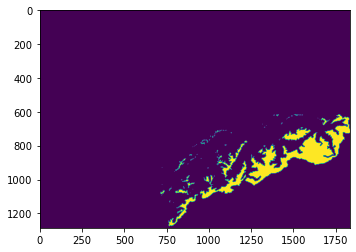

In [9]:
for mask in masks:
    plt.figure()
    plt.imshow(mask)

Let us first try a zonal analysis with a single landscape (e.g., the last LULC map)

In [10]:
lulc_filepath = lulc_filepaths[-1]
lulc_filepath

'../data/raw/AS18_17.tif'

In [11]:
za = pls.ZonalAnalysis(
    lulc_filepath,
    masks,
    attribute_name='elev',
    attribute_values=['0-1000m', '1000-1500m', '1500-2000m', '>2000m'])

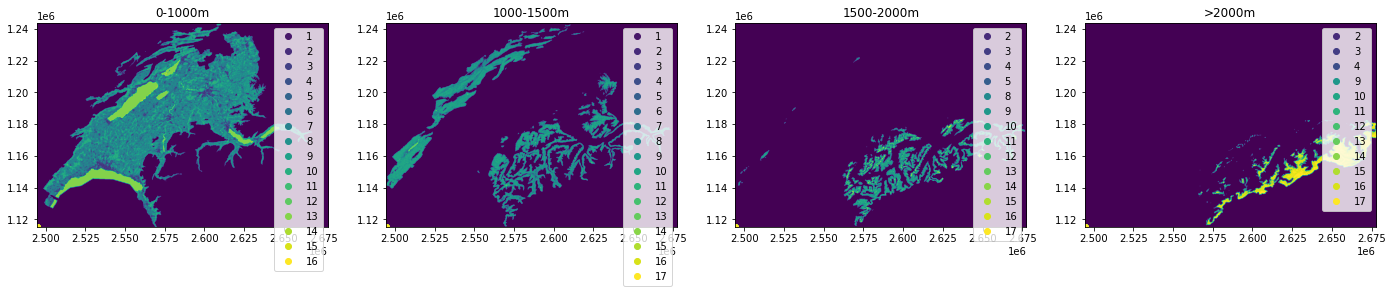

In [12]:
_ = za.plot_landscapes()

We can now compute the landscape metrics for each strata with the `compute_class_metrics_df` method:

In [13]:
class_metrics_df = za.compute_class_metrics_df(metrics=metrics, classes=classes)

In [14]:
class_metrics_df

metric               proportion_of_landscape patch_density edge_density  \
class_val elev                                                            
10        0-1000m                    24.9999      0.926486      24.7716   
          1000-1500m                 50.0481       1.36917      43.4763   
          1500-2000m                 23.9022       2.06236       31.915   
          >2000m                   0.0596736      0.044484     0.132367   
11        0-1000m                 0.00511225    0.00335948      0.01373   
          1000-1500m                0.472416      0.205168      1.17271   
          1500-2000m                 5.06807        1.3334      11.5149   
          >2000m                    0.494749      0.236525     0.990582   
12        0-1000m                    1.56274       1.26287      5.79379   
          1000-1500m                 4.18626       2.94389      14.5938   
          1500-2000m                 4.82811       3.16981      16.2449   
          >2000m                    0.100903      0.085713     0.258224   

metric               fractal_dimension_am  
class_val elev                             
10        0-1000m                 1.19828  
          1000-1500m              1.23893  
          1500-2000m              1.14469  
          >2000m                  1.01591  
11        0-1000m                  1.0163  
          1000-1500m              1.05123  
          1500-2000m               1.0888  
          >2000m                  1.03882  
12        0-1000m                 1.01638  
          1000-1500m              1.02782  
          1500-2000m              1.03157  
          >2000m                  1.01075

And plot metrics with the `plot_metric` method:

Text(0.5, 1.0, 'non-bushy forest')

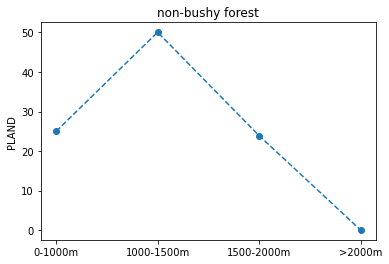

In [15]:
ax = za.plot_metric('proportion_of_landscape', class_val=10)
ax.set_title('non-bushy forest')

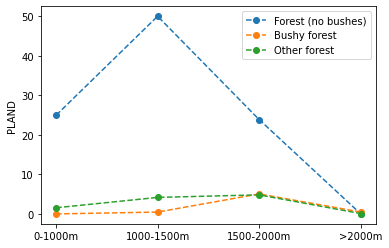

In [16]:
fig, ax = plt.subplots()

for class_val in class_dict:
    class_label = class_dict[class_val]
    za.plot_metric('proportion_of_landscape',
                   class_val=class_val,
                   ax=ax,
                   plot_kws=dict(label=class_label))
ax.legend()

We can define a function that plots a metric for all forest types

In [17]:
def plot_metric_for_forests(metric):
    fig, ax = plt.subplots()

    for class_val in class_dict:
        class_label = class_dict[class_val]
        za.plot_metric(metric,
                       class_val=class_val,
                       ax=ax,
                       plot_kws=dict(label=class_label))
    ax.legend()

    return ax

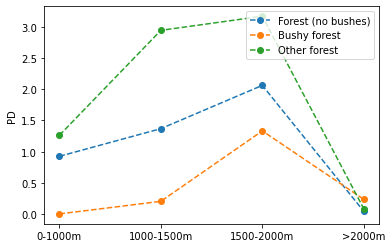

In [18]:
ax = plot_metric_for_forests('patch_density')

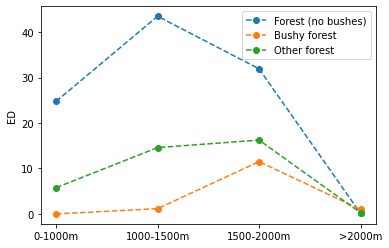

In [19]:
ax = plot_metric_for_forests('edge_density')

## Spatiotemporal zonal analysis

This is an experimental feature

In [20]:
!pip install -e ..

Obtaining file:///home/martibosch/data-science/pylandstats-swiss-forests
  Attempting uninstall: pylandstats-swiss-forests
    Found existing installation: pylandstats-swiss-forests 0.1.0
    Uninstalling pylandstats-swiss-forests-0.1.0:
      Successfully uninstalled pylandstats-swiss-forests-0.1.0
  Running setup.py develop for pylandstats-swiss-forests


In [21]:
from pylandstats_swiss_forests import SpatioTemporalZonalAnalysis

In [22]:
stza = SpatioTemporalZonalAnalysis(
    lulc_filepaths,
    masks,
    dates=years,
    attribute_name='elev',
    attribute_values=['0-1000m', '1000-1500m', '1500-2000m', '>2000m'])

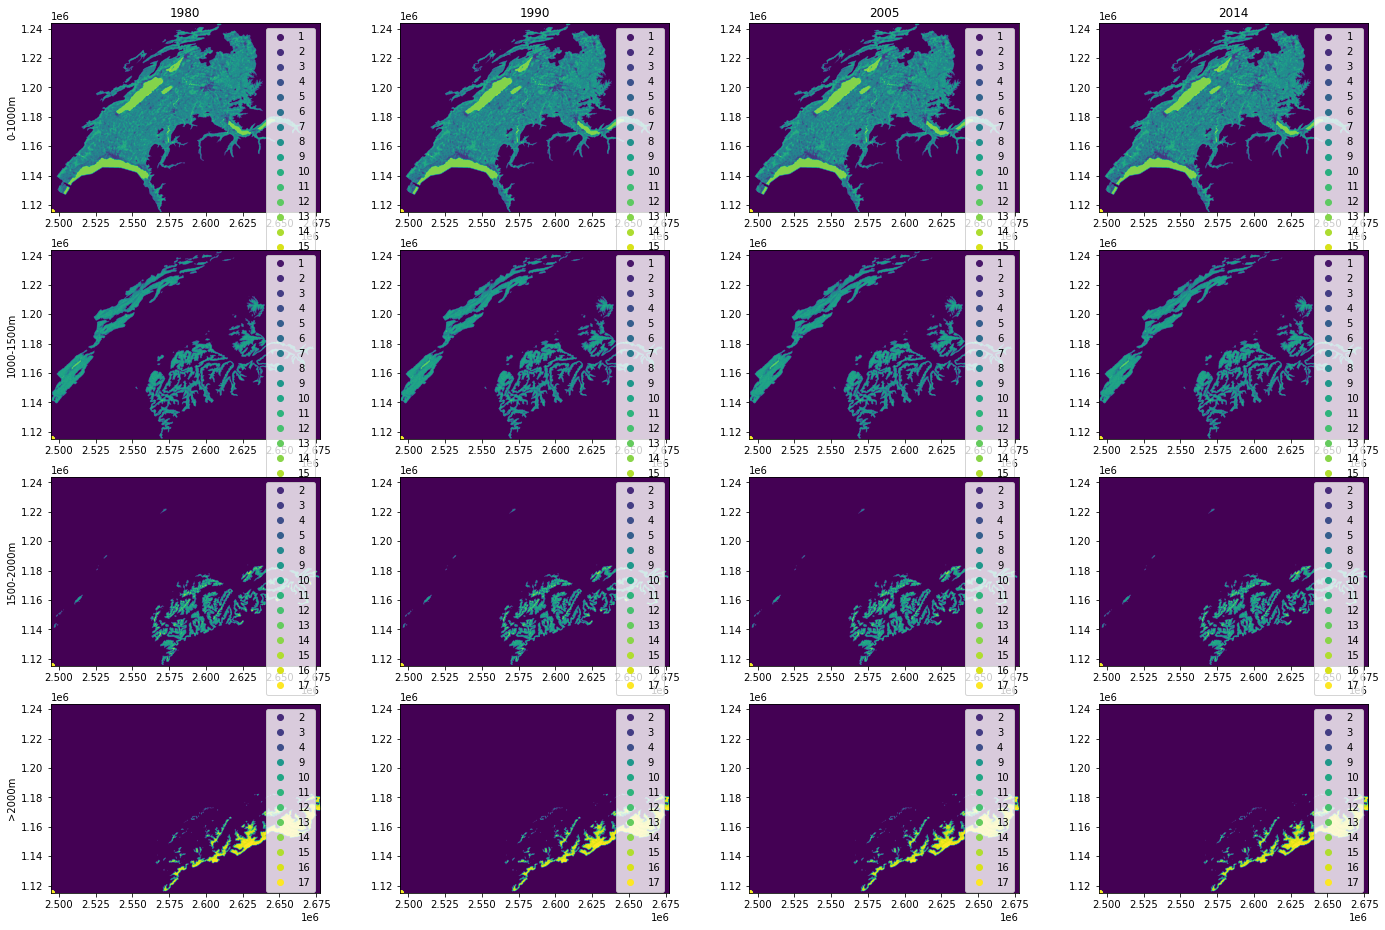

In [23]:
_ = stza.plot_landscapes()

In [24]:
%%time
stza.compute_class_metrics_df(metrics=metrics, classes=classes)

CPU times: user 1min 33s, sys: 446 ms, total: 1min 33s
Wall time: 1min 32s


metric                     proportion_of_landscape patch_density edge_density  \
elev       class_val dates                                                      
0-1000m    10        1980                  24.8081      0.910857       24.432   
                     1990                  24.9752       0.90443      24.5368   
                     2005                  24.9856      0.917868      24.6755   
                     2014                  24.9999      0.926486      24.7716   
           11        1980               0.00555044    0.00365161    0.0154828   
                     1990               0.00555044    0.00335948    0.0154828   
                     2005               0.00598864    0.00365161    0.0169435   
                     2014               0.00511225    0.00335948      0.01373   
           12        1980                  1.65418       1.32393       6.1125   
                     1990                  1.61182       1.29471      5.96936   
                     2005                  1.53762       1.24637        5.706   
                     2014                  1.56274       1.26287      5.79379   
1000-1500m 10        1980                  48.6422        1.4252      44.0929   
                     1990                  49.6162       1.35403      43.7375   
                     2005                  49.7615       1.36804      43.4986   
                     2014                  50.0481       1.36917      43.4763   
           11        1980                 0.325164      0.137788     0.804016   
                     1990                 0.385731      0.162772     0.960352   
                     2005                 0.461438      0.187755       1.1182   
                     2014                 0.472416      0.205168      1.17271   
           12        1980                  4.59811       3.18048      15.9997   
                     1990                  4.37666       3.06351      15.2596   
                     2005                  4.23168       2.96244        14.76   
                     2014                  4.18626       2.94389      14.5938   
1500-2000m 10        1980                  22.0873       2.06401      30.2509   
                     1990                  22.8302        2.0269      30.6888   
                     2005                  23.1139       2.03432      30.9296   
                     2014                  23.9022       2.06236       31.915   
           11        1980                  3.65963       1.03159      8.56443   
                     1990                  4.27809       1.13879      9.78074   
                     2005                  4.82811       1.26083      10.9674   
                     2014                  5.06807        1.3334      11.5149   
           12        1980                  4.97077       3.27784      16.8147   
                     1990                  4.87759       3.23661       16.484   
                     2005                  4.80749       3.18548      16.2185   
                     2014                  4.82811       3.16981      16.2449   
>2000m     10        1980                0.0303793     0.0238695    0.0672685   
                     1990                0.0314643     0.0238695    0.0683534   
                     2005                0.0368892     0.0260394    0.0770332   
                     2014                0.0596736      0.044484     0.132367   
           11        1980                 0.323323      0.172511     0.668345   
                     1990                 0.373231       0.20072     0.782267   
                     2005                 0.448095       0.22242      0.89619   
                     2014                 0.494749      0.236525     0.990582   
           12        1980                0.0726933     0.0618436     0.183361   
                     1990                0.0846281     0.0716084     0.210485   
                     2005                 0.088968     0.0748633     0.223505   
                     2014      

In [25]:
%%time
stza.compute_class_metrics_df(metrics=metrics, classes=classes)

CPU times: user 26.6 s, sys: 43.5 ms, total: 26.7 s
Wall time: 26.6 s


metric                     proportion_of_landscape patch_density edge_density  \
elev       class_val dates                                                      
0-1000m    10        1980                  24.8081      0.910857       24.432   
                     1990                  24.9752       0.90443      24.5368   
                     2005                  24.9856      0.917868      24.6755   
                     2014                  24.9999      0.926486      24.7716   
           11        1980               0.00555044    0.00365161    0.0154828   
                     1990               0.00555044    0.00335948    0.0154828   
                     2005               0.00598864    0.00365161    0.0169435   
                     2014               0.00511225    0.00335948      0.01373   
           12        1980                  1.65418       1.32393       6.1125   
                     1990                  1.61182       1.29471      5.96936   
                     2005                  1.53762       1.24637        5.706   
                     2014                  1.56274       1.26287      5.79379   
1000-1500m 10        1980                  48.6422        1.4252      44.0929   
                     1990                  49.6162       1.35403      43.7375   
                     2005                  49.7615       1.36804      43.4986   
                     2014                  50.0481       1.36917      43.4763   
           11        1980                 0.325164      0.137788     0.804016   
                     1990                 0.385731      0.162772     0.960352   
                     2005                 0.461438      0.187755       1.1182   
                     2014                 0.472416      0.205168      1.17271   
           12        1980                  4.59811       3.18048      15.9997   
                     1990                  4.37666       3.06351      15.2596   
                     2005                  4.23168       2.96244        14.76   
                     2014                  4.18626       2.94389      14.5938   
1500-2000m 10        1980                  22.0873       2.06401      30.2509   
                     1990                  22.8302        2.0269      30.6888   
                     2005                  23.1139       2.03432      30.9296   
                     2014                  23.9022       2.06236       31.915   
           11        1980                  3.65963       1.03159      8.56443   
                     1990                  4.27809       1.13879      9.78074   
                     2005                  4.82811       1.26083      10.9674   
                     2014                  5.06807        1.3334      11.5149   
           12        1980                  4.97077       3.27784      16.8147   
                     1990                  4.87759       3.23661       16.484   
                     2005                  4.80749       3.18548      16.2185   
                     2014                  4.82811       3.16981      16.2449   
>2000m     10        1980                0.0303793     0.0238695    0.0672685   
                     1990                0.0314643     0.0238695    0.0683534   
                     2005                0.0368892     0.0260394    0.0770332   
                     2014                0.0596736      0.044484     0.132367   
           11        1980                 0.323323      0.172511     0.668345   
                     1990                 0.373231       0.20072     0.782267   
                     2005                 0.448095       0.22242      0.89619   
                     2014                 0.494749      0.236525     0.990582   
           12        1980                0.0726933     0.0618436     0.183361   
                     1990                0.0846281     0.0716084     0.210485   
                     2005                 0.088968     0.0748633     0.223505   
                     2014      

Text(0.5, 1.0, 'non-bushy forest')

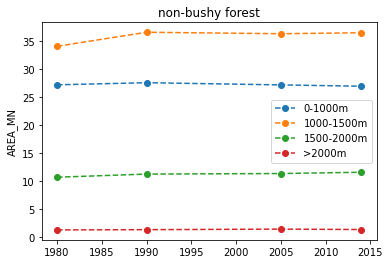

In [26]:
ax = stza.plot_metric('area_mn', class_val=10)
ax.set_title('non-bushy forest')